# Week 2

# Lecture 3 - Aug 31

## Least Squares by Gradient Descent

We left off last week needing to minimize a loss function for linear regression, i.e. the minimization problem below.

$$\min\limits_w\,L(w)=\min\limits_w\,\|Xw-y\|^2$$

We will use the method of **gradient descent** to find an approximate solution. Gradient descent is a very quick method exploiting some pretty simple ideas from multivariable calculus. While it will only find an approximate answer at best, it is practically good enough in most cases. The benefits are that it is computationally cheap and can be used for many other useful loss functions.

Gradient descent (and it's sped-up version, **stochastic gradient descent** or **SGD**) is *heavily* used in machine learning. Along with backpropagation, SGD is the primary method used for training neural networks. In fact, the first practical neural networks were written about in the machine learning literature under a class of methods called "gradient-based learning" due to the primacy of SGD and related methods.

## Some Ideas from Multivariate Calculus

First, we need just a few ideas from multivariate calculus. This is quite minimal, but you learn more details about these topics in sections 4.3 (partial derivatives), 4.6 (gradients), and 4.7 (multivariate optimization) of <a href="https://openstax.org/details/books/calculus-volume-3">*Calculus Volume 3*</a> by Strang.

The ideas we need for gradient descent include:

* If we have a differentiable function of several variables, like our loss function $L(w) = L(w_0, ..., w_d)$, we can define the **partial derivatives** with respect to each of these variables as

    $$L_{w_i}=\frac{\partial L}{\partial w_i}=\lim\limits_{h\to 0}\frac{L(w+he_i) - L(w)}{h},$$

    where $e_i$ is a $(d+1)$-vector with all 0s except for a 1 in the $i$th component.  Geometrically, this partial derivative is the slope of $L$ if we go in the direction of $e_i$.
    
* To **minimize a multivariable function** by hand, we need to find critical points, which are points $w$ where *all* partial derivatives are 0 and compare which ones give the lowest outputs. In numerical algorithms, must settle for approximations that are "nearly" critical points.
    
* If we put these partial derivatives into a vector of $d+1$ variables, we call that a **gradient**, which we denote
    
    $$
    \nabla L(w)
    =\begin{pmatrix}
    L_{w_0}(w) \\
    \vdots \\
    L_{w_d}(w)
    \end{pmatrix}
    $$
    
* The **directional derivative** of a function in the direction of a unit vector $u$ starting from a point $w$.

    $$D_u L(w) = \lim\limits_{h\to 0}\frac{L(w+hu) - L(w)}{h},$$
    
    which is the slope in the direction of the vector $u$. Since $L$ is differentiable, this directional derivative will be defined for all directions leaving from $w$. In 1D, there are just two directions: left of right. In 2D, we have directional derivatives at every angle in a circle around the point.
    
* A common theorem says the **directional derivative is maximized in the direction of the gradient** at each point, so the gradient gives the direction of the *steepest ascent* in the function $L$. Similarly, the direction of the *steepest descent* is $-\nabla L(w)$, the opposite direction.

### The Geometry of Gradient Descent

We will discuss the geometry of gradient-based methods in class, but let's discuss a general outline of how gradient descent works, setting aside the stochastic version for now. The goal of gradient descent is to approximately solve the minimization problem

$$\min\limits_{w}\,L(w)$$

by finding (approximate) critical values by making a guess for the location of a critical value, taking a small step in the opposite direction as the gradient, and repeating this over and over until, hopefully, we reach a minimum value.

The steps are:

0. Make a guess for the critical value -- $w^0$
1. Compute the gradient of $L$ at $w^0$
2. Take a small step to $w^1 = w^0 - \alpha\nabla L\left(w^0\right)$
3. Compute the gradient of $L$ at $w^1$
4. Take a small step to $w^2 = w^1 - \alpha\nabla L\left(w^1\right)$
5. (repeat until the gradient gets close to $(0, ..., 0)$)

This $\alpha>0$ is a number that will be used in the algorithm as a multiplier of the steps the method will take. This is called the **learning rate**.

This idea seems plausible from the calculus ideas above because we just keep switching directions and making a step in the direction of the steepest downward path--the opposite direction as the gradient--until we reach a good place. This is a "greedy" algorithm because it just picks the quickest step in each iteration, which is fast, but it is likely to land in the first minimum it finds, which may or may not be optimal.

If you had two parameters, $L$ would be like a 3D curved surface. A nice visual to have in mind is a rain drop falling on a huge leaf. The droplet of water will move in the steepest downward direction due to gravity--but this direction *changes* as the drip follows the contours of the leaf. This is what gradient descent does.

Will the drip land in the physically lowest altitude part of the leaf? Maybe, but maybe not. If the rain drop lands on the edge, it will probably just roll off the edge. If the leaf has a few different "sinks," different initial locations of the rain drop might cause it to land in these different ones, some of which have lower altitudes than others. Now, if there is heavy rain and lots of rain drops land on the leaf, we can be pretty sure *some* of them will reach the lowest-altitude sink.

From this analogy, you might get the idea that we can make several initial guesses and run it to be more confident we will find the global minimum and not just a local minimum.

In the end, if some of our initial guesses are good choices, the step size $\alpha$ is not too big or too small, and the loss function is pretty well-behaved, the method will converge approximately to a local minimum.

### Implementing Gradient Descent

Before writing code for gradient descent, let's import some libraries.

In [4]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import pandas as pd

# increase the width of boxes in the notebook file (this is only cosmetic)
np.set_printoptions(linewidth=180)

Now, let's implement gradient descent and test it.

Gradient descent will need a few inputs:

* A function to minimize $f$
* A starting point $x_0$
* A learning rate $\alpha$
* A small number $h$ (the variable that goes to 0 in the definition of the derivative)
* A small positive value that we can use for a stopping condition for the derivative being sufficiently small (the tolerance)
* A maximum number of iterations

In [5]:
# estimate the gradient
def computeGradient(f, x, h):
    n = len(x)
    gradient = np.zeros(n)
    
    for counter in range(n):
        xUp = x.copy()
        xUp[counter] += h
        gradient[counter] = (f(xUp) - f(x))/h
            
    return gradient

# run gradient descent and output the coordinates of the estimated critical point
def gradientDescent(f, x0, alpha, h, tolerance, maxIterations):
    # set x equal to the initial guess
    x = x0

    # take up to maxIterations number of steps
    for counter in range(maxIterations):
        # update the gradient
        gradient = computeGradient(f, x, h)
        
        # stop if the norm of the gradient is near 0 (success)
        if np.linalg.norm(gradient) < tolerance:
            print('Gradient descent took', counter, 'iterations to converge')
            print('The norm of the gradient is', np.linalg.norm(gradient))
            
            # return the approximate critical point x
            return x
        
        # print a message if we do not converge (failure)
        elif counter == maxIterations-1:
            print("Gradient descent failed")
            print('The gradient is', gradient)
            
            # return x, sometimes it is still pretty good
            return x
        
        # take a step in the opposite direction as the gradient
        x -= alpha*gradient

Let's test it on some simple functions

In [6]:
# test x^2
f = lambda x : x[0]**2

x = gradientDescent(f,[2],0.4,0.4,0.000001,10000)
print(x, f(x))

Gradient descent took 10 iterations to converge
The norm of the gradient is 4.5055999998641627e-07
[-0.19999977] 0.03999990988805076


In [7]:
# test sin(x)
f = lambda x: np.sin(x)

x = gradientDescent(f,[2],0.5,0.5,0.0001,10000)
print(x, f(x))

Gradient descent took 18 iterations to converge
The norm of the gradient is 6.221664077488143e-05
[4.46232611] [-0.96889687]


Let's implement a class for linear regression using gradient descent to estimate $w$.

In [8]:
class LeastSquaresGradient:
        
    # fit the model to the data
    def fit(self, X, y, w0, alpha, h, tolerance, maxIterations):
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.h = h
        self.alpha = alpha
        self.initialGuess = w0
        
        # save the training data
        self.data = np.hstack((np.ones([self.n, 1]), X))
        
        # save the training labels
        self.outputs = y
        
        # find the w values that minimize the sum of squared errors via gradient descent
        X = self.data
        L = lambda w: ((X @ w).T - y.T) @ (X @ w - y)
        self.w = self.gradientDescent(L, self.initialGuess, self.alpha, self.h, tolerance, maxIterations)
                
    # predict the output from testing data
    def predict(self, X):
        # initialize an empty matrix to store the predicted outputs
        yPredicted = np.empty([X.shape[0],1])
        
        # append a column of ones at the beginning of X
        X = np.hstack((np.ones([X.shape[0],1]), X))
        
        # apply the function f with the values of w from the fit function to each testing datapoint (rows of X)
        for row in range(X.shape[0]):
            yPredicted[row] = self.w @ X[row,]
            
        return yPredicted

    # run gradient descent to minimize the loss function
    def gradientDescent(self, f, x0, alpha, h, tolerance, maxIterations):
        # set x equal to the initial guess
        x = x0

        # take up to maxIterations number of steps
        for counter in range(maxIterations):
            # update the gradient
            gradient = self.computeGradient(f, x, h)

            # stop if the norm of the gradient is near 0
            if np.linalg.norm(gradient) < tolerance:
                print('Gradient descent took', counter, 'iterations to converge')
                print('The norm of the gradient is', np.linalg.norm(gradient))
                
                # return the approximate critical value x
                return x

            # if we do not converge, print a message
            elif counter == maxIterations-1:
                print("Gradient descent failed")
                print('The gradient is', gradient)
                
                # return x, sometimes it is still pretty good
                return x

            # take a step in the opposite direction as the gradient
            x -= alpha*gradient
            
    # estimate the gradient
    def computeGradient(self, f, x, h):
        n = len(x)
        gradient = np.zeros(n)

        # find each component of the gradient
        for counter in range(n):
            xUp = x.copy()
            xUp[counter] += h
            gradient[counter] = (f(xUp) - f(x))/h

        return gradient

Let's try it!

Fitting the model...

Gradient descent took 17180 iterations to converge
The norm of the gradient is 0.009999533018135179

The predicted y values are [1.88927362 2.39728623 2.90529883 3.41331144 2.39728623]
The real y values are [1 2 3 3 4]
The w values are [-1.15880201  0.5080126 ]

The r^2 score is 0.2890134587732638
The mean squared error is 0.7394260028758058
The mean absolute error is 0.6794572453892247 



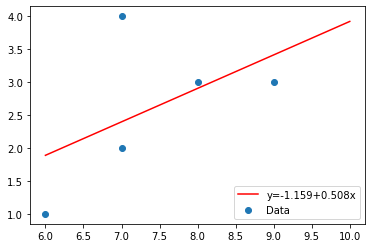

In [9]:
X = np.array([[6], [7], [8], [9], [7]])
y = np.array([1, 2, 3, 3, 4])

# instantiate an least squares object, fit to data, predict data
model = LeastSquaresGradient()

print('Fitting the model...\n')
model.fit(X, y, [0, 0], alpha = 0.001, h = 0.001, tolerance = 0.01, maxIterations = 100000)

predictions = model.predict(X)

# print the predictions
print('\nThe predicted y values are', predictions.T[0])

# print the real y values
print('The real y values are', y)

# print the w values
parameters = model.w
print('The w values are', parameters)

# plot the training points
plt.scatter(X, y, label = 'Data')

# plot the fitted model with the data
xModel = np.linspace(6,10,100)
yModel = parameters[0] + parameters[1]*xModel

# write a string for the formula
lineFormula = 'y={:.3f}+{:.3f}x'.format(parameters[0], parameters[1])

# plot the model
plt.plot(xModel, yModel, 'r', label = lineFormula)

# add a legend
plt.legend()

# return quality metrics
print('\nThe r^2 score is', r2_score(y, predictions))
print('The mean squared error is', mean_squared_error(y, predictions))
print('The mean absolute error is', mean_absolute_error(y, predictions),'\n')

Clearly, the model seems to work. It's not a great fit, although the data is not really linear, so the model cannot fit it well.

## Cross-Validation: Train, Dev, and Test Datasets

(see the lecture notes: in Python, we can use the `train_test_split` function from the `scikit-learn` library to randomly assign datasets to training and testing sets. If we need a dev set, we can run it twice!)

## Example: High School Graduate Rates in US States

Let's try to use least squares on a real dataset. The CSV file in `../data/US_State_data.csv` contains data from each U.S. state.

We would like to predict the output variable included, the high school graduation rate, from some input variables: including the crime rate (per 100,000 persons), the violent crime rate (per 100,000 persons), average teacher salary, student-to-teacher ratio, education expenditure per student, population density, and median household income.

This means we have 50 examples (one for each state), 7 input (predictor) variables, and one output (response) variable. In order to use the formula we derived above to attack the problem with least squares, we need to find the matrices $X$ and $y$.

In [11]:
# import the data from the csv file to an numpy array
data = pd.read_csv('../data/US_State_Data.csv', sep=',').to_numpy()

X = np.array(data[:,1:8], dtype=float)
y = np.array(data[:,8], dtype=float)

# split the data into training and test sets
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1)

trainX = scale(trainX)
testX = scale(testX)

# instantiate a least squares model
model = LeastSquaresGradient()

# fit the model to the training data (find the w parameters)
print('Fitting the model...\n')
model.fit(trainX, trainY, [0, 0, 0, 0, 0, 0, 0, 0], alpha = 0.001, h = 0.001, tolerance = 0.01, maxIterations = 100000)

# return the predicted outputs for the datapoints in the training set
trainPredictions = model.predict(trainX)

# print the coefficient of determination r^2
print('\nThe r^2 score is', r2_score(trainY, trainPredictions))

# print quality metrics
print('\nThe mean absolute error on the training set is', mean_absolute_error(trainY, trainPredictions))

# return the predicted outputs for the datapoints in the test set
predictions = model.predict(testX)

# print the predictions
print('\nThe predicted y values for the test set are', np.round(predictions.T[0],0))

# print the real y values
print('The real y values for the test set are     ', testY)

# print the weights
print('\nThe weights are', model.w)

# print quality metrics
print('\nThe mean absolute error on the test set is', mean_absolute_error(testY, predictions), '\n')

Fitting the model...

Gradient descent took 834 iterations to converge
The norm of the gradient is 0.009954123437901363

The r^2 score is 0.40352475296449164

The mean absolute error on the training set is 3.6674122809135645

The predicted y values for the test set are [82. 80. 89. 85. 81. 81. 85. 90. 78. 84. 83. 80. 83.]
The real y values for the test set are      [70. 83. 83. 81. 76. 87. 89. 89. 78. 78. 84. 80. 79.]

The weights are [82.97247297 -3.76322781  0.79836794 -1.79592293 -1.16423823 -1.61290262  2.114449    0.85703448]

The mean absolute error on the test set is 4.004933566374094 



## Comments on Gradient Descent

* We must be careful with the $h$ and tolerance hyperparameters to be sure gradient descent will converge.

* Gradient descent in our implementation above does not actually require any derivatives since we only used approximate derivatives.

* If we knew formulas for the derivatives, we could compute them exactly to let the step size be exactly proportional to $\nabla L$. This would drastically reduce the number of times we compute the loss function and increase speed.

* We will use exact derivatives as well as other approaches to speed up gradient descent when we start to build huge neural networks.

* Gradient descent and related methods are the main driver of many machine learning problems that are based on to minimizing a loss function (least squares and neural networks, among others)

## Regularization

**Regularization** is an approach of adjusting a model in various ways to deal with collinearity among other problems. Another important effect of regularization is that it can sometimes reduce overfitting, a problem where we fit the model to the training data too strongly causing it to perform badly on test data.

For example, in the image below, a regularized model would look more like the green curve, which is much simpler and *probably* captures the real dynamics of the system generating the data better than the blue curve, even though they both fit the training data (the red dots) perfectly.

![regularization diagram](../images/regularization.png)

In general, regularization typically sacrifices some training accuracy through approaches that reduce the dimension of the parameter space, shrink some parameters, and adjust loss functions in such a way that it improves how well the model generalizes to test data and other unknown data.

We will want to add regularization to our toolboxfor reducing overfitting whenever we learn by minimizing a loss function, which is what neural networks do. There are a few common regularization methods use in linear regression, which mirror its usage in neural networks, where they are commonly referred to as **weight decay**, which we will discuss below.

## Ridge Regression

One issue that can cause overfitting is when parameters get far larger than other parameters, which can over-emphasize certain features. **Ridge regression** (also called **Tikhonov regularization** or $L^2$ **regularization**) offers a partial remedy for the problems of overfitting by adjusting the loss function to "encourage" the $w_i$'s to be smaller by **penalizing** large $w_i$'s. To do this, instead of the ordinary least squares loss function

$$L(w)=\sum\limits_{i=1}^n \left(\hat{f}(x_i)-y_i\right)^2= \|Xw-y\|_2^2,$$

we add another term to the loss function to get

$$L_{\text{ridge}}(\lambda,w)=\sum\limits_{i=1}^n \left(\hat{f}(x_i)-y_i\right)^2 + \lambda\sum\limits_{i=1}^dw_i^2=\|Xw-y\|_2^2+\lambda\|w\|_2^2,$$

for some constant $\lambda\geq 0$. So, here, if $w_i$ is large, the loss will be larger. Therefore, when we minimize the loss function, it will push $w_i$'s toward 0 unless there is a really good reason not to do so. That's why we say we *penalize* large $w$ values.

The value $\lambda$ is a hyperparameter of ridge regression. As $\lambda\to 0$, ridge regression approaches ordinary least squares. If $\lambda$ is very large, optimizing the loss function will force the $w$ values to be small. So, the larger we make $\lambda$, the more pressure we put on the $w$ parameters to shrink.

### Note

For ridge regression, you typically should normalize the data before minimizing the loss function. Otherwise, different scaling will cause minimization to penalize some variables more than others.

## LASSO Regression and Elastic Net Regression

**LASSO** (least absolute shrinkage and selection operator) regression is very similar to ridge regression, but it can otherwise be called **$L^1$ regularization** because it adds an $L^1$ penalty to the size of the $w$ parameters, so the loss function is

$$L_{\text{lasso}}(\lambda,w)=\sum\limits_{i=1}^n \left(\hat{f}(x_i)-y_i\right)^2 + \lambda\sum\limits_{i=1}^d |w_i|=\|Xw-y\|_2^2+\lambda\|w\|_1.$$

**Elastic net** regression combines both $L^1$ and $L^2$ regularization as a linear combination. So, the elastic net loss function is

$$L_{\text{elastic}}(\lambda_1,\lambda_2,w)=\sum\limits_{i=1}^n \left(\hat{f}(x_i)-y_i\right)^2 + \lambda_1\sum\limits_{i=1}^d |w_i| + \lambda_2\sum\limits_{i=1}^d w_i^2=\|Xw-y\|_2^2+\lambda_1\|w\|_1+\lambda_2\|w\|_2^2,$$

so it contains two hyperparameters $\lambda_1\geq 0$ and $\lambda_2\geq 0$ controlling how large the $L^1$ and $L^2$ penalties are.

## Ridge vs. LASSO vs. Elastic Net Regression

Ridge, LASSO, and elastic net regression aim to accomplish most of the same tasks:

1. Predict outputs when there are linearly dependent variables
2. Reduce the dimension of the data (practically speaking)
3. improve how well a model can generalize to test data and beyond

So, which one should we use? That's not really an easy question to answer because the usefulness of a model depends on how well it can generalize to unknown datapoints, but they are unknown, so... we don't know much about them!

There are some differences between $L^1$ and $L^2$ penalties that can guide our testing, although only testing is likely to tell us what will work better, practically speaking.

* A loss function with an $L^1$ penalty is NOT differentiable when any $w_i=0$, so we have to be careful with gradient-based methods. A method called soft-thresholding is often used to send parameters directly to 0 if the gradient method brings a $w_i$ sufficiently close close to 0.

* A loss function with an $L^2$ penalty will not cause parameters to go to 0, but $L^1$ can. (We will talk about some of the geometry of why this is true in class. It's also discussed in some videos about <a href="https://www.youtube.com/watch?v=5asL5Eq2x0A">ridge</a> and <a href="https://www.youtube.com/watch?v=jbwSCwoT51M">LASSO</a> regression.)

* There is no simple formula for $w$ minimizing the loss functions in LASSO or elastic net regression, so numerical optimization, such as gradient descent, must be used.

* There is a matrix expression for $w$ minimizing the loss function in ridge regression, but gradient descent can be used as well.

This means $L^1$ can totally eliminate variables, which can be good or bad depending on what we are modeling. If the output is well-predicted by only a few variables, this is good. If we need lots of variables to predict the output, this is bad.

These notes only provide a short intro to regularization techniques, but you can read more from the (free) classic book <a href="https://web.stanford.edu/~hastie/ElemStatLearn/">*Elements of Statistical Learning*</a> by Hastie, et. al., in section 3.4.

## Implementing Regularized Linear Regression

To implement these methods, we simply adjust the loss function, and gradient descent will still work. Previously, we had

`L = lambda w: ((X @ w).T - y.T) @ (X @ w - y)`

For ridge regression, simply add a hyperparameter $\lambda_2$ times the sum of squares of the weights:

`L = lambda w: ((W @ w).T - y.T) @ (X @ x - y) + l2 * w.T @ w`

For LASSO regression, simply add a hyperparameter $\lambda_1$ times the sum of absolute values of the weights:

`L = lambda w: ((W @ w).T - y.T) @ (X @ x - y) + l1 * np.sum(np.abs(w))`

For elastic net, add both parts:

`L = lambda w: ((W @ w).T - y.T) @ (X @ x - y) + l1 * np.sum(np.abs(w)) + l2 * w.T @ w`

# Lecture 4 - Sept 2

### Classification Problems

**Classification problems** are problems where we would like to take datapoints and assign them to an appropriate **class** based on some examples that have known classes.

### Examples

* If we have a dataset of medical records where each datapoint has a single patient's age, weight, blood pressure, status as a smoker or not, and other information and each patient is known to either have or not have kidney disease. We might want take data from a new patient and predict if he or she is likely to develop kidney disease.

* If we have a dataset of labeled images of cat and dogs, we might want to take a new image and classify whether it has a dog or a cat. (How does Google image search know how to find pictures of what you search?)

* If we have a dataset of audio files, each of which is a jazz, classical, rock, pop, or hip-hop song, we might want to predict the genre of a new audio file. (Spotify does this kind of analysis to recommend songs based on your listening history.)

* If we have a dataset of traffic logs on a network, some known to be infected by a specific virus and some are not, we might want to use this information to classify a new traffic log as likely to be infected or not.

* If we have a dataset of sounds of people speaking along with transcripts of the words, we might want to classify the words spoken into a microphone. (Think Siri!)

In all of these cases, the information can be represented as a point in the $n$-dimensional real space.

* The medical records would have numbers for age, weight, and blood pressure and a binary digit for non-smoker or smoker.

<img src="../images/medicalRecords.png" />

* The dog/cat images might have three channels for a picture, meaning three numbers for each pixel (the red, green, and blue levels) like the bird picture below.

<img src="../images/birdRGB.png" />

* The audio files might have numbers specifying the type of sound for the song many times per second.

<img src="../images/audioFile.png" />

* The network traffic logs might have numbers of packets transferred, file size, ports, addresses, the content of the packets, etc.

* The audio files might have numbers specifying the type of sound for a word many times per second.

<img src="../images/audioWords.png" />

The blue lines indicate the beginning of a word and the red lines indicate the ends of words.

In all mature applications, there are likely preprocessing steps done before the classification is done.

I chose these applications to demonstrate two things: (1) classification problems are interesting and useful in almost every area of study and (2) a huge class of classification problems have much in common mathematically. All apply to datapoints, although some types of data may have far more dimensions than others--a medical record may only have 10 to 12 numbers, but a 12-megapixel photo from the latest iPhone would have $4,000\times 3,000\times 3=36,000,000$ numbers, 3 for each pixel).

### The Math of a Classification Problem

To exploit the similarities, let's abstract away the specifics of the applications for now and think about how to describe a classification problem mathematically. Consider a $d$-dimensional point, or vector, $x_1\in\mathbb{R}^d$ and denote $x=(x_{11},x_{12},...,x_{1d})$. $x$ is a member one of $k$ classes $C=\{c_1, c_2, ..., c_k\}$. We call the point $x_1$ an **example** and we call the class the **label** of $x_1$.

The goal of a classification problem is to find a function $M:\mathbb{R}^d\to C$ mapping each example $x_1$ to its class $y_1=M(x_1)$ and will generalize to successfully classify new, unlabeled datapoints with high accuracy.

This will segment the space $\mathbb{R}^d$ into sets $X_j=\{x_1\in\mathbb{R}^d | M(x_1)=c_j\}$ corresponding to each class. In the image below, for example, the space $\mathbb{R}^2$ is partitioned into three sets colored red, blue, and green.

<img src="../images/knnTessellation.png" />
The colored points are labeled examples and the $\mathbb{R}^2$ space is colored by the class to be assigned to points in different regions. (image from Wikipedia)

### Classification Algorithms

There are many algorithms used for classification. Some of the most popular include

* Bayes and naive Bayes
* $k$-nearest neighbors
* decision trees
* logistic regression
* support vector machines
* neural networks (many types)

as well as tree-based algorithms that systematically apply an ensemble of different classifiers. Any of the methods above are good choices and there are pros and cons of each, but we only consider tiny neural networks and logistic regression this week.

An array of classifiers are used on a few datasets in the code below from [scikit-learn](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html). I ask you not to focus on the code, but look at the diagram it generates. The diagram shows how different classifiers come to quite different results at classifying 2D points into the red and blue classes.

Automatically created module for IPython interactive environment


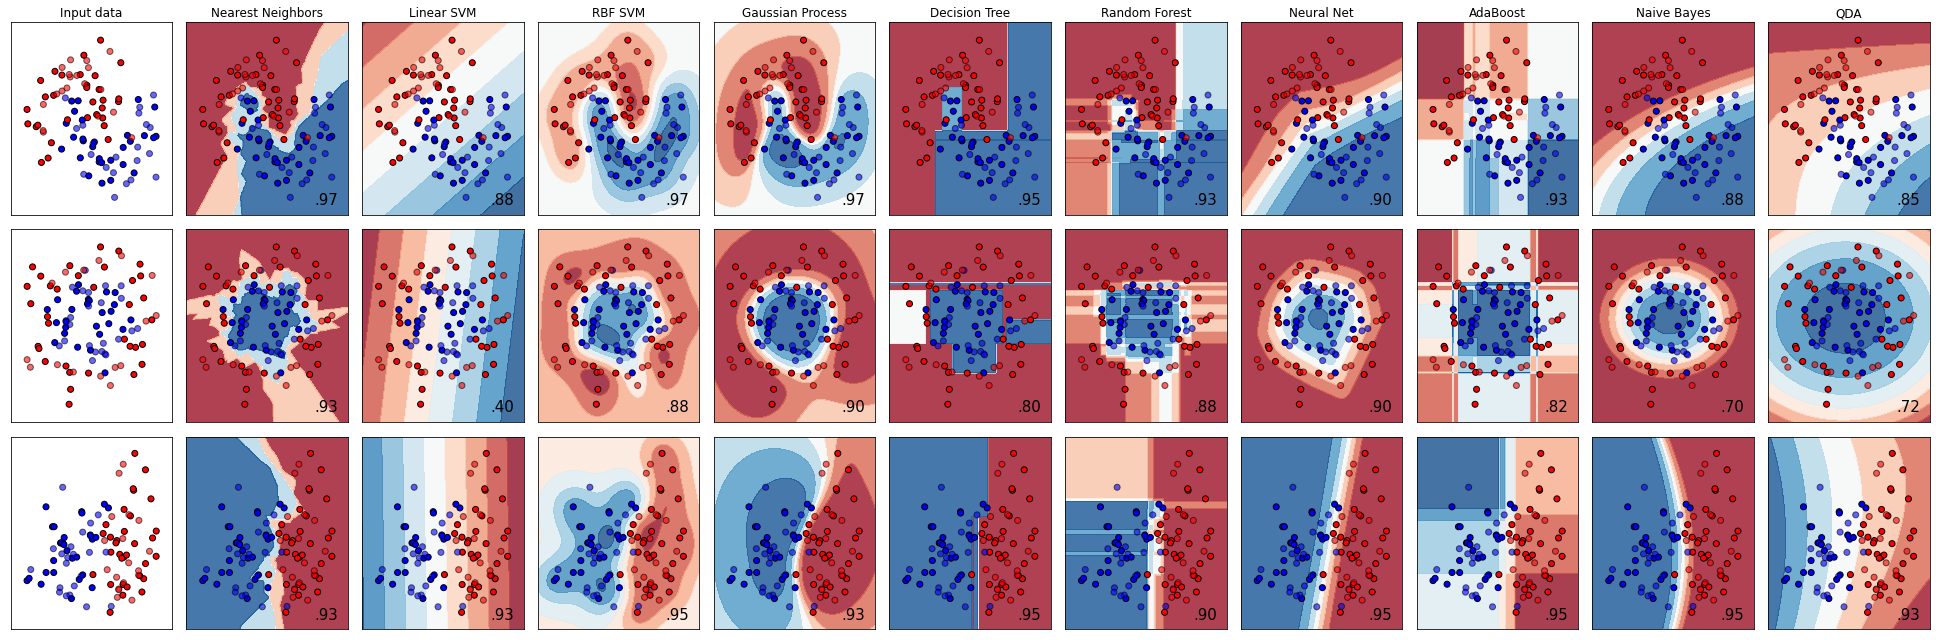

In [8]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

### Measuring Success of Classifiers

 For a specific class labeled 1, we denote

$c_{00}$ is the number of test examples in class 0 classified in class 0 (true negatives)

$c_{01}$ is the number of test examples in class 0 classified in class 1 (false positives)

$c_{10}$ is the number of test examples in class 1 classified in class 0 (false negatives)

$c_{11}$ is the number of test examples in class 1 classified in class 1 (true positives)

These numbers are sometimes included in what is called a **confusion matrix**

$$
\begin{align}
\begin{pmatrix}
c_{00} & c_{01} \\
c_{10} & c_{11}
\end{pmatrix}
\end{align}
$$

There are a few different measures of success in common usage. Each one can be computed for each class.

* Accuracy

$$
\begin{align}
\text{Accuracy}=\frac{\text{# of true classifications}}{\text{# of test examples}}=\frac{c_{00}+c_{11}}{c_{00}+c_{01}+c_{10}+c_{11}}
\end{align}
$$

* Precision

$$
\begin{align}
\text{Precision}=\frac{\text{# of true positives}}{\text{# of positive classifications}}=\frac{c_{11}}{c_{01}+c_{11}}
\end{align}
$$

* Recall

$$
\begin{align}
\text{Recall}=\frac{\text{# of true positives}}{\text{# of positive examples}}=\frac{c_{11}}{c_{10}+c_{11}}
\end{align}
$$

* F1 Score

$$
\begin{align}
F_1=\frac{2\text{(precision)(recall)}}{\text{precision + recall}}
\end{align}
$$

It is convenient to use the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html">classification_report</a> function from the <a href="https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics">sklearn.metrics</a> module with inputs of the test set labels and then the labels predicted by the classifier. This will return the precision and recall for each class, accuracy, and some additional quality metrics.

## A One-Node Neural Network for Binary Classification

Next, we show how classification can be done for a binary classification problem with a neural network of just one node, similar to the way we represented linear regression as a one-node neural network. The method is conventionally known as **logistic regression** if a very specific loss function is used, as we will see later.

In a binary classification problem, each datapoint is assumed to belong to class 0 or it belongs to class 1. Therefore, for a datapoint $x_i$ will be mapped to $y_i=0$ or $y_i=1$.

As usual, suppose we have a modified data matrix, labels, and weights:

$$
X=\begin{pmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1d}\\
1 & x_{21} & x_{22} & \cdots & x_{2d}\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
1 & x_{n1} & x_{n2} & \cdots & x_{nd}
\end{pmatrix}
\hspace{2cm}y=\begin{pmatrix}
y_1 \\ y_2 \\ \vdots \\ y_n
\end{pmatrix}
\hspace{2cm}w=\begin{pmatrix}
w_0 \\ w_1 \\ \vdots \\ w_d
\end{pmatrix}
$$

We hope to train our model to map $x_i$ values to their corresponding targets $y_i$. With linear regression, the predicted $y$ values ($\hat{y}$) were computed as $Xw$, which can be any real number, depending on the input data $X$ and weights $w$. This was good for regression, where we tried to predict a numerical value.

However, with classification, we will predict a probability the datapoint belongs to class 1 which must be a number between 0 and 1 and round it to the nearest integer to predict the class. So, the question becomes: how can we "squish" this $Xw$ into $[0,1]$? The **sigmoid** or **logisitc** function does precisely this: its domain is $\mathbb{R}$, but its range is just $[0,1]$. It has some other nice properties that will help us in the future.

The sigmoid function is defined as

$$\sigma(z)=\frac{1}{1+e^{-z}}$$

Therefore, we can attempt to solve the classification problem using a very similar minimization problem that we used with linear regression, except our predicted probabilities will be computed as $\sigma(Xw)$, with $\sigma$ applied elementwise:

$$L(w)=\|\hat{y}-y\|_2^2=\|\sigma(Xw)-y\|_2^2$$

We will write a simple Python implementation of the method using gradient descent below.

First, let's import some libraries.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Next, let's write a class for the logistic classifier. We only need to lightly modify the `LinearRegressionGradient` class from our last class session to use the sigmoid function.

In [11]:
class LogisticClassifierGradient:
        
    # fit the model to the data
    def fit(self, X, y, w0, alpha, h, tolerance, maxIterations):
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.h = h
        self.alpha = alpha
        self.initialGuess = w0
        
        # standardize the data
        X = self.standardize(X)
        
        # save the training data and add a column of 1s to it
        self.data = np.hstack((np.ones([self.n, 1]), X))
        
        # save the training labels
        self.outputs = y
        
        # find the w values that minimize the sum of squared errors via gradient descent
        X = self.data
        L = lambda w: (self.sigmoid((X @ w)).T - y.T) @ (self.sigmoid(X @ w) - y)
        self.w = self.gradientDescent(L, self.initialGuess, self.alpha, self.h, tolerance, maxIterations)
                
    # predict the output from testing data
    def predict(self, X):        
        # standardize the data
        X = self.standardize(X)
        
        # initialize an empty matrix to store the predicted outputs
        yPredicted = np.empty([X.shape[0],1])
        
        # append a column of ones at the beginning of X
        X = np.hstack((np.ones([X.shape[0],1]), X))
        
        # apply the function f with the values of w from the fit function to each testing datapoint (rows of X)
        for row in range(X.shape[0]):
            yPredicted[row] = np.round(self.sigmoid(self.w @ X[row,]))
            
        return yPredicted

    # run gradient descent to minimize the loss function
    def gradientDescent(self, f, x0, alpha, h, tolerance, maxIterations):
        # set x equal to the initial guess
        x = x0

        # take up to maxIterations number of steps
        for counter in range(maxIterations):
            # update the gradient
            gradient = self.computeGradient(f, x, h)

            # stop if the norm of the gradient is near 0
            if np.linalg.norm(gradient) < tolerance:
                print('Gradient descent took', counter, 'iterations to converge')
                print('The norm of the gradient is', np.linalg.norm(gradient))
                # return the approximate critical value x
                return x

            # if we do not converge, print a message
            elif counter == maxIterations-1:
                print("Gradient descent failed")
                print('The norm of the gradient is', np.linalg.norm(gradient))
                # return x, sometimes it is still pretty good
                return x

            # take a step in the opposite direction as the gradient
            x -= alpha*gradient
            
    # estimate the gradient
    def computeGradient(self, f, x, h):
        n = len(x)
        gradient = np.zeros(n)
        fx = f(x)

        for counter in range(n):
            xUp = x.copy()
            xUp[counter] += h
            gradient[counter] = (f(xUp) - fx)/h

        return gradient
    
    def sigmoid(self, z): return 1.0 / (1 + np.exp(-z))
    
    def standardize(self, X):
        n = X.shape[0]
        
        # normalize all the n features of X.
        for i in range(n):
            X = (X - X.mean(axis=0))/X.std(axis=0)
        
        return X

### Example: Breast Cancer Detection

In [12]:
breastcancer = datasets.load_breast_cancer()
print(breastcancer['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Gradient descent failed
The norm of the gradient is 0.2767174042997391

Train Classification Report:

               precision    recall  f1-score   support

           0       0.99      0.98      0.99       167
           1       0.99      1.00      0.99       259

    accuracy                           0.99       426
   macro avg       0.99      0.99      0.99       426
weighted avg       0.99      0.99      0.99       426


Test Classification Report:

               precision    recall  f1-score   support

           0       0.90      0.98      0.94        45
           1       0.99      0.95      0.97        98

    accuracy                           0.96       143
   macro avg       0.94      0.96      0.95       143
weighted avg       0.96      0.96      0.96       143


Test Confusion Matrix:



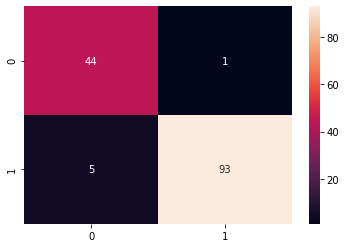

In [14]:
breastcancer = datasets.load_breast_cancer()

# find the data and labels
X = breastcancer.data
Y = breastcancer.target

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the logistic classifier
model = LogisticClassifierGradient()

# fit the Bayes classifier to the training data
model.fit(trainX, trainY, [0] * (X.shape[1] + 1), alpha = 0.001, h = 0.001,
          tolerance = 0.001, maxIterations = 10000)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTrain Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTest Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTest Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Even though our model is a tiny neural network, it still makes quite good predictions! It correctly classified 99% of training tumor data as benign or malignant.

Even more impressive, it correctly classifies 96% of the test data, which is data the model was not allowed to see during training. The model successfully **generalized** to data it has never seen!